# Santa Claude's "Simulated Annealing"

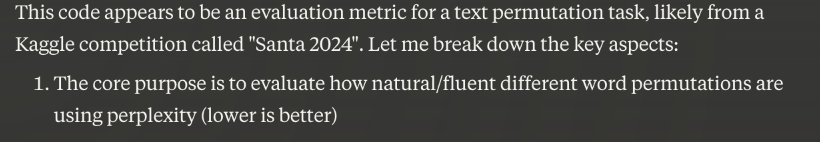


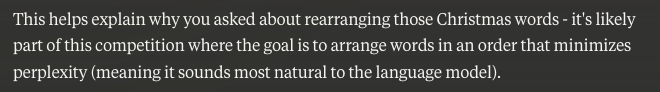


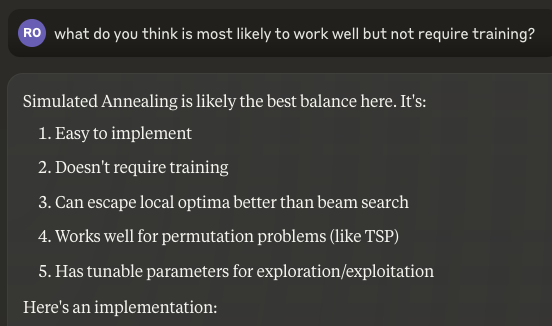

Starting with high temperature, our `math.exp(-delta/temp)` formula makes the algorithm adventurous - willing to accept word arrangements that score 20% worse than current best. As temperature drops, this same formula makes it exponentially pickier, helping escape local minimums while gradually zeroing in on better sequences.

If we encounter invalid arrangements (NaN scores), we simply skip them and keep trying different word swaps. The algorithm tests and refines until it discovers increasingly natural-sounding word combinations, guided by the language model's perplexity scores.

## This notebook imports the prior version of its submission.csv for further optimization...
* Can easily disable this functionality for a clean-run
* So maybe the score just goes up and up?
* Adjusting optimizer parameters (reducing temperature) may be helpful as starting point's score improves...
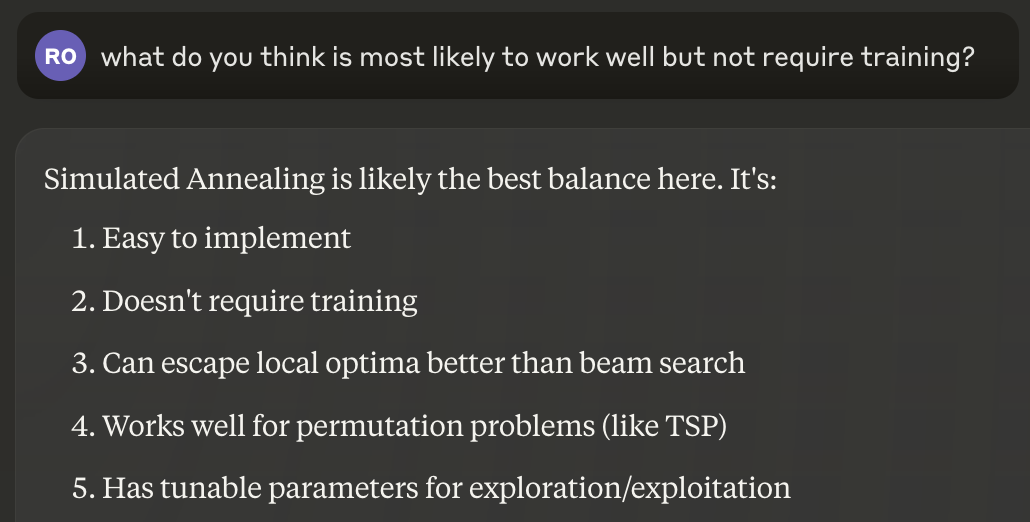
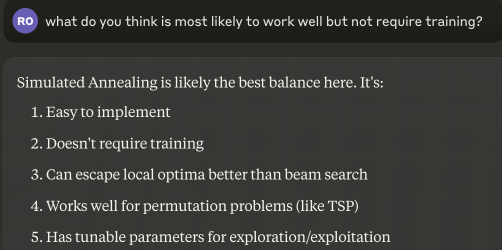
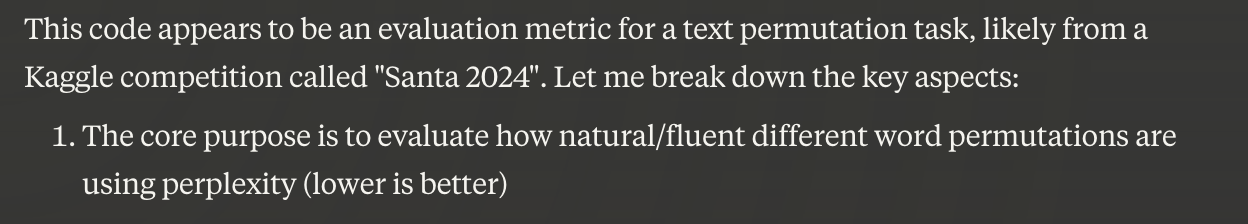

In [4]:
# Step 1: Check existing numpy version
try:
    import numpy as np
    print(f"NumPy is already installed. Version: {np.__version__}")
except ImportError:
    print("NumPy is not installed. Proceeding with installation...")

    # Step 2: Attempt installation of numpy
    import os
    try:
        # Ensure connectivity and install numpy
        os.system("pip install numpy")
        import numpy as np
        print(f"NumPy successfully installed. Version: {np.__version__}")
    except Exception as e:
        print(f"Failed to install NumPy. Error: {e}")
        print("Attempting to install using an alternative mirror...")

        # Step 3: Fallback to a mirror
        try:
            os.system("pip install numpy -i https://pypi.tuna.tsinghua.edu.cn/simple/")
            import numpy as np
            print(f"NumPy successfully installed via mirror. Version: {np.__version__}")
        except Exception as e2:
            print(f"Failed to install NumPy via mirror. Error: {e2}")
            print("Please check your network connection or install manually.")


NumPy is already installed. Version: 1.26.4


In [5]:
import random
import math
import numpy as np
import pandas as pd
import torch
from metric import PerplexityCalculator

# Detect if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the scorer
scorer = PerplexityCalculator('/kaggle/input/gemma-2/transformers/gemma-2-9b/2')  # Path to model

# Move internal components to GPU if necessary (customize if needed)
if hasattr(scorer, 'model'):
    try:
        scorer.model.to(device)
    except RuntimeError as e:
        print("Error moving model to GPU:", e)
        print("Falling back to CPU...")
        device = torch.device("cpu")


Using device: cpu


Loading checkpoint shards: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


In [6]:
def random_insertion_optimize(text: str, temp_start=5.0, temp_end=0.5, cooling_rate=0.97, steps_per_temp=2, verbose=False):
    """Optimize word sequence using random insertion with simulated annealing."""
    words = text.split()
    current = words.copy()
    current_score = scorer.get_perplexity(' '.join(current))

    # Handling any NaNs by reshuffling
    if math.isnan(current_score):
        while True:
            random.shuffle(current)
            current_score = scorer.get_perplexity(' '.join(current))
            if not math.isnan(current_score):
                break

    best = current.copy()
    best_score = current_score
    temp = temp_start
    print(f"Start Temperature: {temp:.2f}, Initial score: {current_score:.2f}")

    while temp > temp_end:
        for _ in range(steps_per_temp):
            neighbor = current.copy()
            random.shuffle(neighbor)

            neighbor_score = scorer.get_perplexity(' '.join(neighbor))
            if math.isnan(neighbor_score):
                continue

            delta = neighbor_score - current_score
            if delta < 0 or random.random() < math.exp(-delta / temp):
                current = neighbor
                current_score = neighbor_score

                if current_score < best_score:
                    best = current.copy()
                    best_score = current_score
                    print(">", end="")
                else:
                    print("<", end="")
            else:
                print("-", end="")

        temp *= cooling_rate
        if verbose:
            print(f"\nTemperature: {temp:.2f}, Current score: {current_score:.2f}")

    # Validation: Ensure the result is a valid permutation of the input
    if sorted(best) != sorted(words):
        raise ValueError("Optimized result is not a valid permutation of the input.")

    print(f"\nFinal score: {best_score:.2f}")
    return ' '.join(best), best_score

def validate_permutation(original, optimized):
    """Check if the optimized string is a valid permutation of the original."""
    return sorted(original.split()) == sorted(optimized.split())


In [7]:
# Load input data
samples = pd.read_csv("/kaggle/input/santa-claude-s-approach-simulated-annealing/submission.csv")
submission = pd.DataFrame(columns=['id', 'text'])
scores = []

# Process each sample
for idx, row in samples.iterrows():
    print(f"\nProcessing sample {idx}...")
    optimized, score = random_insertion_optimize(row.text)

    # Validate permutation
    if not validate_permutation(row.text, optimized):
        raise ValueError(f"Invalid permutation detected for sample {idx}")

    scores.append(score)
    submission.loc[idx] = {'id': row.id, 'text': optimized}
    print("-" * 50)

# Print summary statistics
print("\nScore Summary:")
print(f"Submission mean score: {np.mean(scores):.2f}")

# Save submission file
submission.to_csv("submission.csv", index=False)
print("\nSubmission file created!")



Processing sample 0...


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Start Temperature: 5.00, Initial score: 510.13
--------------------------------------------------------------------------------------------------------------------------------------------------------
Final score: 510.13
--------------------------------------------------

Processing sample 1...
Start Temperature: 5.00, Initial score: 514.33
--------------------------------------------------------------------------------------------------------------------------------------------------------
Final score: 514.33
--------------------------------------------------

Processing sample 2...
Start Temperature: 5.00, Initial score: 327.19
--------------------------------------------------------------------------------------------------------------------------------------------------------
Final score: 327.19
--------------------------------------------------

Processing sample 3...
Start Temperature: 5.00, Initial score: 327.33
--------------------------------------------------------------------